In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import time
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from copy import deepcopy

In [3]:
from spacetime import SpaceTime
from spacetime.simulate import Simulator
from spacetime.models_att import AutoEncoder
from spacetime.training_att import LagrangeLoss, ActionOpt
from spacetime.training_att import train, truth_evaluation
from spacetime.utils_att import Parameters, spacetime_mutilator, graph_clipper
from spacetime.sampler import NodeData, GraphSampler

In [4]:
node_dict = {0:[0,1], 1:[2], 2:[3], 3:[4]}
node_list = [j for i in node_dict.values() for j in i]
n_nodes = sum(map(len, node_dict.values()))
from spacetime.training_att import h_A, h_A_timed

sim_params = Parameters(graph_type='erdos-renyi', graph_degree=3, edge_types=2, 
                        sem_type='nonlinear_2', x_dims=1, sem_noise='linear-gauss', 
                        noise_scale = 0.6, sample_size=7500, seed=42)

mod_params = Parameters(n_nodes=n_nodes, x_dims=1, h_dims=64, z_dims=1, graph_threshold=0.4)

trn_params = Parameters(batch_size=100, epochs=5)

opt_params = Parameters(constraint=lambda x: h_A_timed(x, node_dict),
                        lr=3e-3, l=1e-2, c=1.0, h=np.inf, tau=1e-10, 
                        max_iters=50, h_tol=1e-8)

simulating a random 3-degree erdos-renyi dag with range (0.5, 2.0) (seed 0)


array([[0.        , 0.        , 0.89683342, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.0563694 , 1.41814358],
       [0.        , 0.        , 0.        , 0.75007504, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.15554793],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

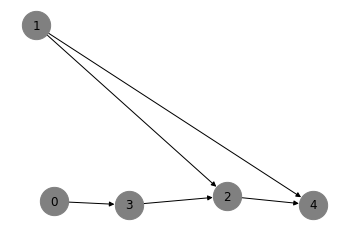

In [5]:
g = SpaceTime.from_spacelike(node_list, simulate=True,
                             degree=sim_params.graph_degree, 
                             graph_type=sim_params.graph_type, 
                             w_range=(0.5,2.0), force_positive=True, seed=0)
g.graph.edges[(1,3)]['weight'] *= 2.0
g.graph.edges[(2,3)]['weight'] *= 0.5
g.show_adj()
g.draw_graph()

In [6]:
col_plot_dict = {0:(4,3), 1:(4,1), 2:(3,2), 3:(2,0)}
mutilate = 3
observe = 4
latent = 1

In [7]:
g.data = Simulator.sem(graph=g.graph, n=sim_params.sample_size, x_dims=sim_params.x_dims, 
                       sem_type=sim_params.sem_noise, linear_type=sim_params.sem_type, 
                       noise_scale=sim_params.noise_scale, seed=sim_params.seed)
train_loader, test_loader = g.torch_loader(g.data, trn_params.batch_size)

simulating 7500 samples from a linear-gauss sem with nonlinear_2 causal effects


In [8]:
n_trials = 10

loss_log = {k:[] for k in ('elbo', 'kld', 'nll')}
param_log = {k:[] for k in ('lr', 'l', 'c', 'h')}

shd_trials, err_trials = list(), list()
graph_trials = list()

for trial in range(n_trials):
    shd_train, err_train = list(), list()
    #===================================
    # load modules
    #===================================
#     autoencoder = AutoEncoder(MLPEncoder(mod_params.n_nodes, mod_params.x_dims, mod_params.h_dims, mod_params.z_dims).double(),
#                               MLPDecoder(mod_params.z_dims, mod_params.x_dims, n_hid=mod_params.h_dims).double())
    autoencoder = AutoEncoder(mod_params)
    optimizerL = ActionOpt(autoencoder, opt_params, h_factor=0.25*2, c_factor=10.0/2)
    
    #===================================
    # train model
    #===================================
    
    t_total = time.time()
    while optimizerL._iter < optimizerL.max_iter:
        for epoch in range(trn_params.epochs):
            train(autoencoder, train_loader, LagrangeLoss(opt=optimizerL))
            shd, err = truth_evaluation(g.show_adj(), optimizerL, mod_params.graph_threshold)
            shd_train.append(shd)
            err_train.append(err)
        
        print("Iteration: %s, Best Epoch: %s/%s"%(optimizerL._iter, optimizerL.best_epoch, trn_params.epochs))
        print("   ELBO: {:.7f}, KL: 10^{:.3f}, NLL: 10^{:.3f} || h: 10^{:.3f}, c: 10^{:.3f}, l: {:.7f}".format(
            optimizerL.min_elbo, np.log10(optimizerL.min_kld), np.log10(optimizerL.min_nll),
            np.log10(optimizerL.h), np.log10(optimizerL.c), optimizerL.l)
        )

        # update parameters
        optimizerL.iterate()
        if optimizerL.h <= optimizerL.h_tol:
            break

    print("\nTrial %s finished in %s seconds"%(trial, time.time() - t_total))
    print('Best ELBO Stats: shd %s err %s\n'%(shd, err))

    shd_trials.append(shd_train)
    err_trials.append(err_train)
    graph_trials.append(optimizerL.show_adj(mod_params.graph_threshold))
    
    for k,v in loss_log.items():
        v += [optimizerL.log[k]]
        
    for k,v in param_log.items():
        v += [optimizerL.log[k]]
    
pass;

Iteration: 0, Best Epoch: 3/5
   ELBO: 0.0363778, KL: 10^-1.502, NLL: 10^-2.606 || h: 10^inf, c: 10^0.000, l: 0.0100000
Iteration: 1, Best Epoch: 3/5
   ELBO: 0.0271857, KL: 10^-1.726, NLL: 10^-2.606 || h: 10^-1.326, c: 10^0.000, l: 0.0572553
Iteration: 2, Best Epoch: 1/5
   ELBO: 0.0206647, KL: 10^-1.820, NLL: 10^-2.606 || h: 10^-1.742, c: 10^0.000, l: 0.0753697
Iteration: 3, Best Epoch: 2/5
   ELBO: 0.0171268, KL: 10^-1.935, NLL: 10^-2.606 || h: 10^-2.086, c: 10^0.000, l: 0.0835653
Iteration: 4, Best Epoch: 0/5
   ELBO: 0.0119383, KL: 10^-1.988, NLL: 10^-3.403 || h: 10^-1.933, c: 10^0.000, l: 0.0952462
Iteration: 5, Best Epoch: 3/5
   ELBO: 0.0110415, KL: 10^-2.089, NLL: 10^-3.403 || h: 10^-2.366, c: 10^0.000, l: 0.0995546
Iteration: 6, Best Epoch: 4/5
   ELBO: 0.0062886, KL: 10^-2.206, NLL: 10^-4.419 || h: 10^-2.366, c: 10^0.699, l: 0.0995546
Iteration: 7, Best Epoch: 0/5
   ELBO: 0.0062470, KL: 10^-2.259, NLL: 10^-4.419 || h: 10^-2.970, c: 10^0.699, l: 0.1049087
Iteration: 8, Best 

Iteration: 9, Best Epoch: 0/5
   ELBO: 0.0054623, KL: 10^-2.290, NLL: 10^-4.924 || h: 10^-3.481, c: 10^2.097, l: 0.1801653
Iteration: 10, Best Epoch: 4/5
   ELBO: 0.0048619, KL: 10^-2.316, NLL: 10^-4.944 || h: 10^-3.481, c: 10^2.796, l: 0.1801653
Iteration: 11, Best Epoch: 4/5
   ELBO: 0.0048515, KL: 10^-2.339, NLL: 10^-4.944 || h: 10^-3.952, c: 10^2.796, l: 0.2499616
Iteration: 12, Best Epoch: 4/5
   ELBO: 0.0043819, KL: 10^-2.364, NLL: 10^-5.027 || h: 10^-3.952, c: 10^3.495, l: 0.2499616
Iteration: 13, Best Epoch: 3/5
   ELBO: 0.0043401, KL: 10^-2.387, NLL: 10^-5.027 || h: 10^-4.426, c: 10^3.495, l: 0.3672037
Iteration: 14, Best Epoch: 4/5
   ELBO: 0.0039548, KL: 10^-2.409, NLL: 10^-5.027 || h: 10^-4.426, c: 10^4.194, l: 0.3672037
Iteration: 15, Best Epoch: 1/5
   ELBO: 0.0038611, KL: 10^-2.430, NLL: 10^-5.027 || h: 10^-4.817, c: 10^4.194, l: 0.6054069
Iteration: 16, Best Epoch: 2/5
   ELBO: 0.0036190, KL: 10^-2.451, NLL: 10^-5.027 || h: 10^-4.817, c: 10^4.893, l: 0.6054069
Iteration

Iteration: 23, Best Epoch: 4/5
   ELBO: 0.0032153, KL: 10^-2.506, NLL: 10^-4.896 || h: 10^-6.951, c: 10^7.689, l: 8.3715162
Iteration: 24, Best Epoch: 4/5
   ELBO: 0.0030368, KL: 10^-2.527, NLL: 10^-4.896 || h: 10^-6.951, c: 10^8.388, l: 8.3715162
Iteration: 25, Best Epoch: 4/5
   ELBO: 0.0028692, KL: 10^-2.548, NLL: 10^-4.896 || h: 10^-7.430, c: 10^8.388, l: 17.4390098

Trial 4 finished in 35.901326179504395 seconds
Best ELBO Stats: shd 0 err 1.3120550776139135

Iteration: 0, Best Epoch: 4/5
   ELBO: 0.0545886, KL: 10^-1.443, NLL: 10^-1.771 || h: 10^inf, c: 10^0.000, l: 0.0100000
Iteration: 1, Best Epoch: 4/5
   ELBO: 0.0368256, KL: 10^-1.636, NLL: 10^-1.864 || h: 10^-1.277, c: 10^0.000, l: 0.0628909
Iteration: 2, Best Epoch: 4/5
   ELBO: 0.0155469, KL: 10^-1.814, NLL: 10^-3.777 || h: 10^-1.277, c: 10^0.699, l: 0.0628909
Iteration: 3, Best Epoch: 4/5
   ELBO: 0.0155469, KL: 10^-1.865, NLL: 10^-3.777 || h: 10^-2.030, c: 10^0.699, l: 0.1095809
Iteration: 4, Best Epoch: 4/5
   ELBO: 0.01

Iteration: 11, Best Epoch: 4/5
   ELBO: 0.0045877, KL: 10^-2.345, NLL: 10^-4.733 || h: 10^-4.372, c: 10^3.495, l: 0.4075498
Iteration: 12, Best Epoch: 3/5
   ELBO: 0.0043939, KL: 10^-2.370, NLL: 10^-4.733 || h: 10^-4.372, c: 10^4.194, l: 0.4075498
Iteration: 13, Best Epoch: 4/5
   ELBO: 0.0041906, KL: 10^-2.395, NLL: 10^-4.733 || h: 10^-4.790, c: 10^4.194, l: 0.6611459
Iteration: 14, Best Epoch: 3/5
   ELBO: 0.0039109, KL: 10^-2.418, NLL: 10^-4.733 || h: 10^-4.790, c: 10^4.893, l: 0.6611459
Iteration: 15, Best Epoch: 4/5
   ELBO: 0.0037339, KL: 10^-2.442, NLL: 10^-4.733 || h: 10^-5.301, c: 10^4.893, l: 1.0520022
Iteration: 16, Best Epoch: 4/5
   ELBO: 0.0034862, KL: 10^-2.465, NLL: 10^-4.733 || h: 10^-5.301, c: 10^5.592, l: 1.0520022
Iteration: 17, Best Epoch: 3/5
   ELBO: 0.0033993, KL: 10^-2.488, NLL: 10^-4.733 || h: 10^-5.675, c: 10^5.592, l: 1.8769631
Iteration: 18, Best Epoch: 4/5
   ELBO: 0.0031446, KL: 10^-2.512, NLL: 10^-4.733 || h: 10^-5.981, c: 10^5.592, l: 2.2854898
Iteratio

Iteration: 23, Best Epoch: 3/5
   ELBO: 0.0021271, KL: 10^-2.680, NLL: 10^-5.297 || h: 10^-6.303, c: 10^7.689, l: 3.0301097
Iteration: 24, Best Epoch: 3/5
   ELBO: 0.0020945, KL: 10^-2.702, NLL: 10^-5.297 || h: 10^-7.164, c: 10^7.689, l: 6.3755571
Iteration: 25, Best Epoch: 3/5
   ELBO: 0.0019335, KL: 10^-2.721, NLL: 10^-5.481 || h: 10^-7.164, c: 10^8.388, l: 6.3755571
Iteration: 26, Best Epoch: 1/5
   ELBO: 0.0019333, KL: 10^-2.739, NLL: 10^-5.481 || h: 10^-7.668, c: 10^8.388, l: 11.6135645

Trial 9 finished in 38.583396911621094 seconds
Best ELBO Stats: shd 0 err 0.961271657827976



0.0000 +- 0.0000
1.2481 +- 0.0978


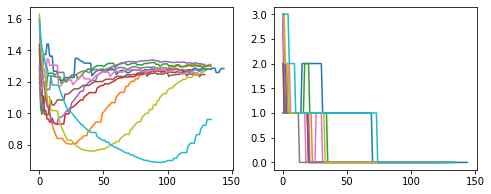

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (8,3))

for trial in range(n_trials):
    axs[0].plot(range(len(err_trials[trial])), err_trials[trial])
    axs[1].plot(range(len(shd_trials[trial])), shd_trials[trial])
    
shd_finals = [shd_trials[i][-1] for i in range(n_trials)]
err_finals = [err_trials[i][-1] for i in range(n_trials)]
print("{:0.4f} +- {:0.4f}".format(np.mean(shd_finals), np.std(shd_finals)))
print("{:0.4f} +- {:0.4f}".format(np.mean(err_finals), np.std(err_finals)))
pass;

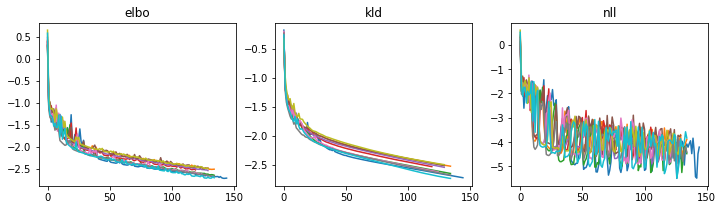

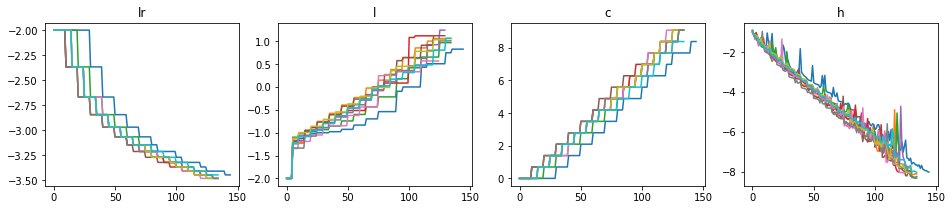

In [10]:
fig, axs = plt.subplots(1, 3, figsize = (12,3))

for i, (k,v) in enumerate(loss_log.items()):
    axs[i].set_title(r'%s'%k)
    for trial in range(n_trials):
        axs[i].plot(range(len(v[trial])), np.log10(v[trial]))
plt.show()

fig, axs = plt.subplots(1, 4, figsize = (16,3))

for i, (k,v) in enumerate(param_log.items()):
    axs[i].set_title(r'%s'%k)
    for trial in range(n_trials):
        axs[i].plot(range(len(v[trial])), np.log10(v[trial]))
pass;

In [13]:
blah

NameError: name 'blah' is not defined

## SEM Evaluation

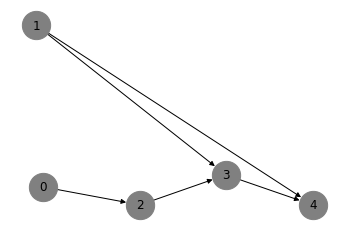

In [14]:
g_learned = SpaceTime.from_adjacency(optimizerL.show_adj(mod_params.graph_threshold))
g_learned.draw_graph()

In [15]:
autoencoder.eval()

data = next(iter(test_loader))[0].double()
noise, _, Wa_train = autoencoder.encode(data)
preds = autoencoder.decode(noise, g_learned.torch_graph(), Wa_train)
pass;

In [16]:
X_train = NodeData(g.data, bins=10)
Z_learned = NodeData(noise.detach().numpy(), bins=10)
X_learned = NodeData(preds.detach().numpy(), bins=10)

pX_train = GraphSampler(g, X_train)
pZ_learned = GraphSampler(g_learned, Z_learned)
pX_learned = GraphSampler(g_learned, X_learned)

In [17]:
Z_resampled_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000), bins = Z_learned.edges())
Z_resampled_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000), bins = Z_learned.edges())

Fit joint KDE for (0,) in 0.0004918575286865234 seconds
Computed joint distro for (0,) in 0.007577419281005859 seconds
Fit joint KDE for (1,) in 0.0004456043243408203 seconds
Computed joint distro for (1,) in 0.007494211196899414 seconds
Fit conditional KDE for 2 wrt (0,) in 0.0009250640869140625 seconds
Computed conditional distro for 2 wrt (0,) in 0.08576154708862305 seconds
Fit conditional KDE for 3 wrt (1, 2) in 0.00023555755615234375 seconds
Computed conditional distro for 3 wrt (1, 2) in 1.6137747764587402 seconds
Fit conditional KDE for 4 wrt (1, 3) in 0.0007958412170410156 seconds
Computed conditional distro for 4 wrt (1, 3) in 1.8336212635040283 seconds
Computed joint distro for (0,) in 0.0018668174743652344 seconds
Computed joint distro for (1,) in 0.0021665096282958984 seconds
Computed conditional distro for 2 wrt (0,) in 0.0586395263671875 seconds
Computed conditional distro for 3 wrt (1, 2) in 1.51474928855896 seconds
Computed conditional distro for 4 wrt (1, 3) in 1.78811

In [18]:
pZ_resampled_cdf = GraphSampler(g_learned, Z_resampled_cdf)
pZ_resampled_pdf = GraphSampler(g_learned, Z_resampled_pdf)

In [19]:
preds_resampled_cdf = autoencoder.decode(g_learned.torch_data(Z_resampled_cdf.data()).double(), g_learned.torch_graph(), Wa_train)
preds_resampled_pdf = autoencoder.decode(g_learned.torch_data(Z_resampled_pdf.data()).double(), g_learned.torch_graph(), Wa_train)
X_resampled_cdf = NodeData(preds_resampled_cdf.detach().numpy(), bins=15)
X_resampled_pdf = NodeData(preds_resampled_pdf.detach().numpy(), bins=15)

pX_resampled_cdf = GraphSampler(g_learned, X_resampled_cdf)
pX_resampled_pdf = GraphSampler(g_learned, X_resampled_pdf)

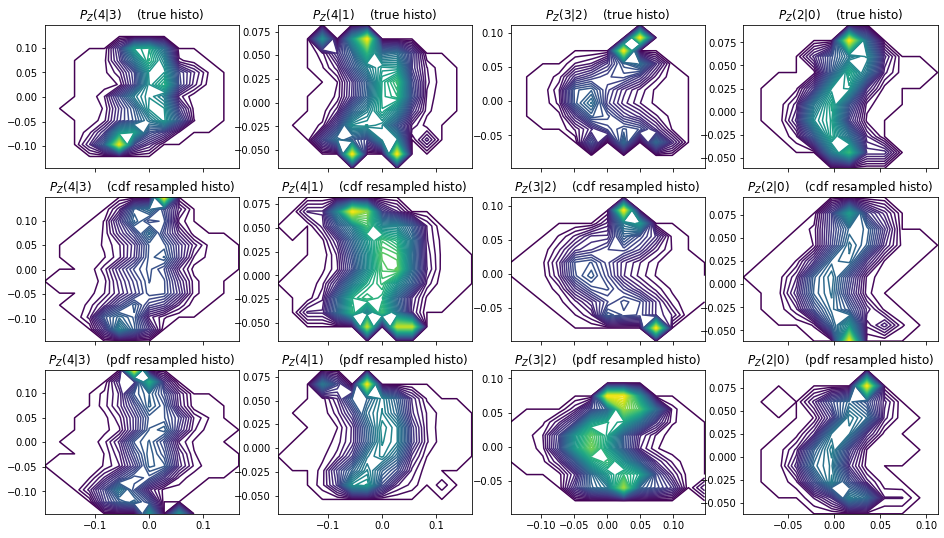

In [20]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_Z(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pZ_learned.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_Z(%s|%s)$    (cdf resampled histo)'%(d,c))
    axs[1][col].contour(*pZ_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pZ_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

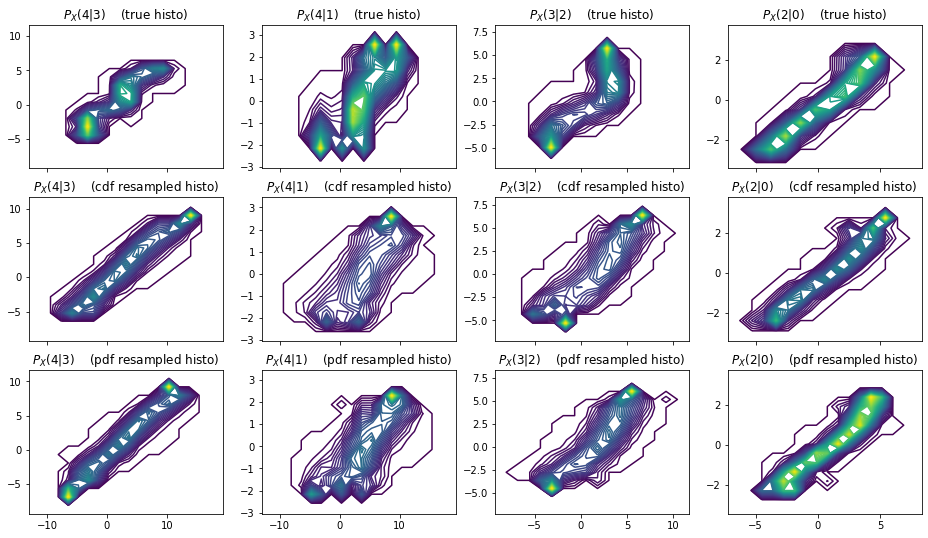

In [21]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(d,c))
    axs[1][col].contour(*pX_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
# plt.plot(pX_train.node_data.axes(0)[0], pX_train.histogram.compute_joint(0)[1])
# plt.plot(pX_train.node_data.axes(1)[0], pX_train.histogram.compute_joint(1)[1])
# plt.show()
# plt.plot(pX_mutil.node_data.axes(0)[0], pX_mutil.histogram.compute_joint(0)[1])
# plt.plot(pX_mutil.node_data.axes(1)[0], pX_mutil.histogram.compute_joint(1)[1])
# pass;

In [ ]:
# truth = pX.histogram.compute_conditional(4,(2,))[1]
# generated = pX_new.histogram.compute_conditional(4,(2,))[1]
# _, truth_ = pX.histogram._epsilonize((), truth)
# _, generated_ = pX.histogram._epsilonize((), generated)
# np.sum(truth_*np.log((truth_/generated_)))/np.prod(truth.shape)

In [ ]:
# np.sum(truth)
# np.sum(truth_*np.log((truth_/generated_)), axis=0, keepdims=True)
# np.exp(np.sum(-truth_*np.log((truth_/(truth_*0.1)))))

## Graph Mutilation Tests

In [22]:
g_mutil = spacetime_mutilator(g, mutilate=[mutilate])
g_mutil.data = Simulator.sem(graph=g_mutil.graph, n=10000, x_dims=sim_params.x_dims, 
                       sem_type=sim_params.sem_noise, linear_type=sim_params.sem_type, 
                       noise_scale=sim_params.noise_scale, seed=sim_params.seed)

simulating 10000 samples from a linear-gauss sem with nonlinear_2 causal effects


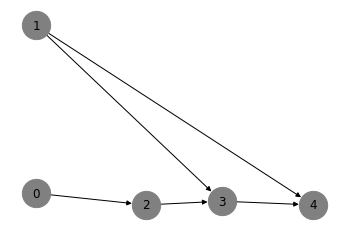

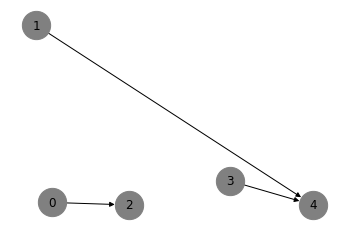

In [23]:
g_learned.draw_graph()

g_learned_mutil = spacetime_mutilator(g_learned, mutilate=[mutilate])
g_learned_mutil.draw_graph()

In [24]:
X_mutil = NodeData(g_mutil.data, bins=10)
pX_mutil = GraphSampler(g, X_mutil)

In [25]:
Z_resampled_mutil_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
Z_resampled_mutil_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
pZ_resampled_mutil_cdf = GraphSampler(g_learned, Z_resampled_mutil_cdf)
pZ_resampled_mutil_pdf = GraphSampler(g_learned, Z_resampled_mutil_pdf)

Fit joint KDE for (3,) in 0.0005853176116943359 seconds
Computed joint distro for (3,) in 0.007673740386962891 seconds
Computed joint distro for (3,) in 0.023521900177001953 seconds


In [26]:
preds_resampled_mutil_cdf = autoencoder.decode(g_learned_mutil.torch_data(Z_resampled_mutil_cdf.data()).double(), 
                                       g_learned_mutil.torch_graph(), Wa_train)
preds_resampled_mutil_pdf = autoencoder.decode(g_learned_mutil.torch_data(Z_resampled_mutil_pdf.data()).double(), 
                                       g_learned_mutil.torch_graph(), Wa_train)
X_resampled_mutil_cdf = NodeData(preds_resampled_mutil_cdf.detach().numpy(), bins=X_learned.edges())
X_resampled_mutil_pdf = NodeData(preds_resampled_mutil_pdf.detach().numpy(), bins=X_learned.edges())
pX_resampled_mutil_cdf = GraphSampler(g_learned_mutil, X_resampled_mutil_cdf)
pX_resampled_mutil_pdf = GraphSampler(g_learned_mutil, X_resampled_mutil_pdf)

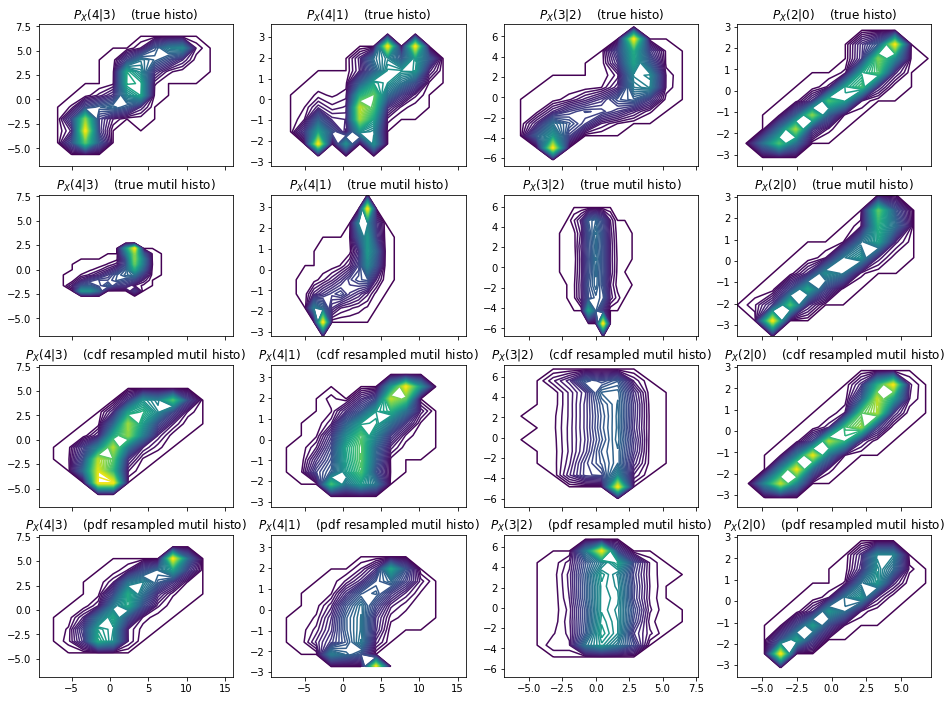

In [27]:
fig, axs = plt.subplots(4, 4, sharex='col', sharey='col', figsize = (16,12))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(d,c))
    axs[1][col].contour(*pX_mutil.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_mutil_cdf.get_contour_conditional(d,c), levels=50)
    axs[3][col].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(d,c))
    axs[3][col].contour(*pX_resampled_mutil_pdf.get_contour_conditional(d,c), levels=50)
    
pass;

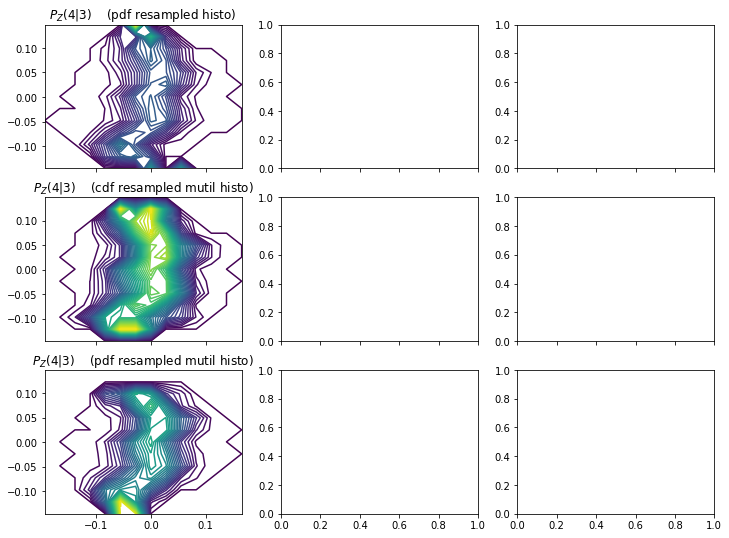

In [28]:
fig, axs = plt.subplots(3, 3, sharex='col', sharey='col', figsize = (12,9))

axs[0][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[0][0].contour(*pZ_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_Z(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][0].contour(*pZ_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][0].contour(*pZ_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)
pass;

In [29]:
def Pi_UNj_DOk(i, j, k, histogram):
    do = np.zeros(histogram.compute_joint(i, k)[1].shape)
    latent = histogram.compute_joint(j)[1]
    
    for n in range(len(latent)):
        do += histogram.compute_conditional(i,(j,k))[1][:,n,:]*latent[n]
    return do

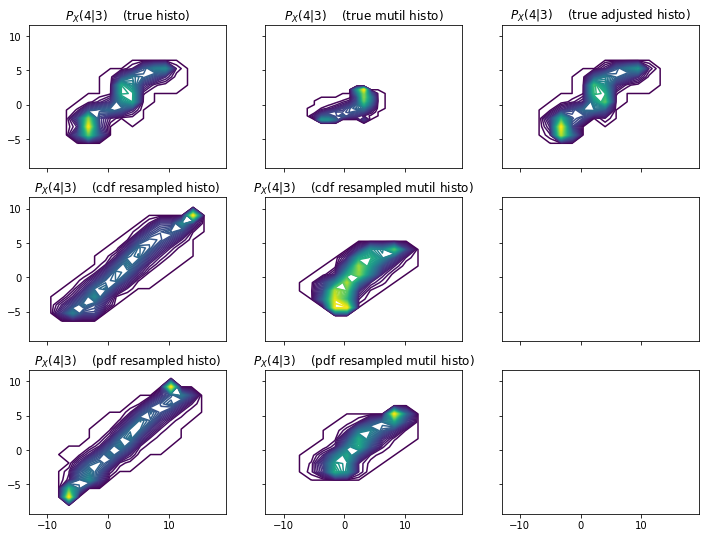

In [30]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (12,9))
axs[0][0].set_title(r'$P_X(%s|%s)$    (true histo)'%(observe,mutilate))
axs[0][0].contour(*pX_train.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(observe,mutilate))
axs[1][0].contour(*pX_resampled_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[2][0].contour(*pX_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)

axs[0][1].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(observe,mutilate))
axs[0][1].contour(*pX_mutil.get_contour_conditional(observe,mutilate), levels=50)
axs[1][1].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][1].contour(*pX_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][1].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][1].contour(*pX_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)



axs[0][2].set_title(r'$P_X(%s|%s)$    (true adjusted histo)'%(observe,mutilate))
axs[0][2].contour(*np.meshgrid(*pX_train.node_data.axes(observe,mutilate)), 
                  Pi_UNj_DOk(observe,latent,mutilate, pX_train.histogram).T, levels=50)
pass;

In [ ]:
# shd_trials

#### noise = 0.1
# [5, 5, 3, 3, 5, 3, 7, 4, 5, 6, 6, 3, 4, 3, 5, 3, 4, 6, 4, 4]
# 4.4 +- 1.2
# [5, 3, 3, 2, 5, 5, 5, 7, 4, 2, 3, 2, 4, 4, 5, 4, 3, 4, 5, 4]
# 3.95 +- 1.24

#### noise = 0.3
# [1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 2, 3]
# 2.05 +- 0.589

#### noise = 0.5
# [1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0]
# 1.2 +- 0.60

#### noise = 0.7
# [0, 1, 0, 1, 1, 3, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
# 0.65 +- 0.726

In [ ]:
# shd_trials
# np.mean(shd_trials)
# np.std(shd_trials)

####### node_dict = {0:[0,1], 1:[2,3,4], 2:[5,6]}
#### noise = 0.05
### h_A experiments
# [9, 9, 11, 9, 9, 10, 9, 6, 9, 7]
# 8.8 +- 1.32664991614216
### h_A_ordered experiments
# [2, 6, 7, 5, 5, 4, 6, 7, 6, 6]
# 5.4 +- 1.42828568570857

#### noise = 0.1
### h_A experiments
# [7, 8, 7, 9, 8, 8, 4, 9, 5, 8]
# 7.3 +- 1.5524174696260025
### h_A_ordered experiments
# [1, 1, 5, 4, 4, 4, 4, 5, 3, 1]
# 3.2 +- 1.5362291495737217